# Загрузка датасета

In [1]:
import pandas as pd
import numpy as np
from __future__ import print_function
import argparse
import os
import sys
import subprocess
import datetime
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import seaborn as sns

import librosa
import matplotlib.pyplot as plt

In [ ]:
! pip install -q youtube_dl

     |████████████████████████████████| 1.9 MB 5.3 MB/s 


In [ ]:
def get_formatted_time(seconds):
    return str(datetime.timedelta(seconds=seconds))


def dl_youtube(link, target_file):
    p = subprocess.Popen(["youtube-dl",
                          "-f", "best",
                          "--merge-output-format", "wav",
                          "--restrict-filenames",
                          "--socket-timeout", "20",
                          "-iwc",
                          "--write-info-json",
                          '--write-annotations',
                          '--prefer-ffmpeg',
                          link,
                          '-o', target_file],
                         )
    out, err = p.communicate()


def prepare_data(file, target_dir):

    temp_directory = os.path.abspath(os.path.join(target_dir, "youtube_videos_temp"))
    if not os.path.exists(temp_directory):
        os.makedirs(temp_directory)

    print ("here")
    with open(file) as f:
        next(f)
        for l in f:
            l = l.strip()
            if len(l) > 0:
                link, start, end, video, utterance = l.split(',')[:5]

                result_dir = os.path.join(os.path.join(target_dir, video))
                if not os.path.exists(result_dir):
                    os.makedirs(result_dir)
                result_filename = os.path.abspath(os.path.join(result_dir, utterance[:-4])) + ".wav"

                target_file = os.path.abspath(os.path.join(temp_directory, video + ".wav"))
                if not os.path.exists(target_file):
                    dl_youtube(link, target_file)

                p = subprocess.call(["ffmpeg",
                                     "-y",
                                     "-i", target_file,
                                     "-ss", get_formatted_time(float(start)),
                                     "-ab", "160k", "-ac", "2",
                                     "-ar", "44100",
                                     "-to", get_formatted_time(float(end)),
                                     result_filename]
                                    )

In [2]:
data_path = "/content/drive/MyDrive/OMGAudio/"

train_file = data_path + "Raw/omg_TrainVideos.csv"
train_dir = data_path + "train/"

valid_file = data_path + "Raw/omg_ValidationVideos.csv"
valid_dir = data_path + "valid/"

In [ ]:
prepare_data(train_file, train_dir)
prepare_data(valid_file, valid_dir)

# Загрузка данных

In [3]:
train_videos = pd.read_csv(train_file)
train_texts = pd.read_csv(data_path + "Raw/omg_TrainTranscripts.csv")

valid_videos = pd.read_csv(valid_file)
valid_texts = pd.read_csv(data_path + "Raw/omg_ValidationTranscripts.csv")

In [ ]:
train_texts

,link,video,utterance,transcript
19,https://www.youtube.com/watch?v=Zrx1BfbOysg,8c56c5ac5,utterance_3.mp4,I think I made a big mistake I'm afraid memori...
20,https://www.youtube.com/watch?v=Zrx1BfbOysg,8c56c5ac5,utterance_4.mp4,my anime fans dear yours
21,https://www.youtube.com/watch?v=Zrx1BfbOysg,8c56c5ac5,utterance_5.mp4,I'm
22,https://www.youtube.com/watch?v=Zrx1BfbOysg,8c56c5ac5,utterance_6.mp4,I'm remembering something something I want to ...
23,https://www.youtube.com/watch?v=Zrx1BfbOysg,8c56c5ac5,utterance_7.mp4,how are you
...,...,...,...,...
1584,https://www.youtube.com/watch?v=f7W-4HEGtHk,664ea0ccc_15,utterance_331.mp4,but they're wife doesn't miscarry or the daugh...
1585,https://www.youtube.com/watch?v=f7W-4HEGtHk,664ea0ccc_15,utterance_332.mp4,who do you think they are praying to are you g...
1586,https://www.youtube.com/watch?v=f7W-4HEGtHk,664ea0ccc_15,utterance_333.mp4,Bible Dennis and you go to your church and wit...
1587,https://www.youtube.com/watch?v=f7W-4HEGtHk,664ea0ccc_15,utterance_334.mp4,N21 November 17th and he does not like being s...


In [ ]:
train_videos

,link,start,end,video,utterance,arousal,valence,EmotionMaxVote
19,https://www.youtube.com/watch?v=Zrx1BfbOysg,4.663918,10.410530,8c56c5ac5,utterance_3.mp4,0.228972,-0.445180,5
20,https://www.youtube.com/watch?v=Zrx1BfbOysg,10.493814,13.575331,8c56c5ac5,utterance_4.mp4,0.192382,-0.259251,5
21,https://www.youtube.com/watch?v=Zrx1BfbOysg,13.991753,17.489691,8c56c5ac5,utterance_5.mp4,0.145036,-0.476546,5
22,https://www.youtube.com/watch?v=Zrx1BfbOysg,18.072680,22.986451,8c56c5ac5,utterance_6.mp4,0.154583,-0.391777,5
23,https://www.youtube.com/watch?v=Zrx1BfbOysg,23.319588,24.318999,8c56c5ac5,utterance_7.mp4,0.151967,-0.246856,5
...,...,...,...,...,...,...,...,...
1584,https://www.youtube.com/watch?v=f7W-4HEGtHk,1963.991899,1974.544044,664ea0ccc_15,utterance_331.mp4,0.880881,0.347520,4
1585,https://www.youtube.com/watch?v=f7W-4HEGtHk,1974.210379,1984.720816,664ea0ccc_15,utterance_332.mp4,0.645236,0.378545,0
1586,https://www.youtube.com/watch?v=f7W-4HEGtHk,1984.136903,1994.605632,664ea0ccc_15,utterance_333.mp4,0.709436,0.183120,0
1587,https://www.youtube.com/watch?v=f7W-4HEGtHk,1994.063426,2004.490447,664ea0ccc_15,utterance_334.mp4,0.685798,0.093559,0


# Предобработка и извлечение признаков (аудио)

In [102]:
def get_wavs(videos, folder):
    wavs = []
    for video, utterance in zip(videos.video, videos.utterance):
        path_to_file = f"{data_path}{folder}/{video}/{utterance}"
        wavs.append(torchaudio.load(f"{path_to_file[:-4]}.wav"))

    return wavs


def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1, figsize=(12,6))
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [7]:
train_wavs = get_wavs(train_videos, "train")
valid_wavs = get_wavs(valid_videos, "valid")

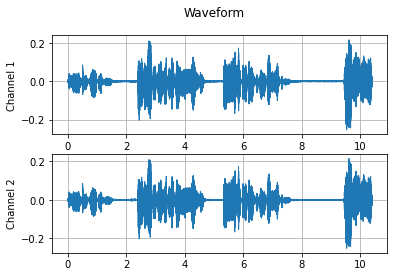

In [ ]:
plot_waveform(train_wavs[250][0], train_wavs[250][1])

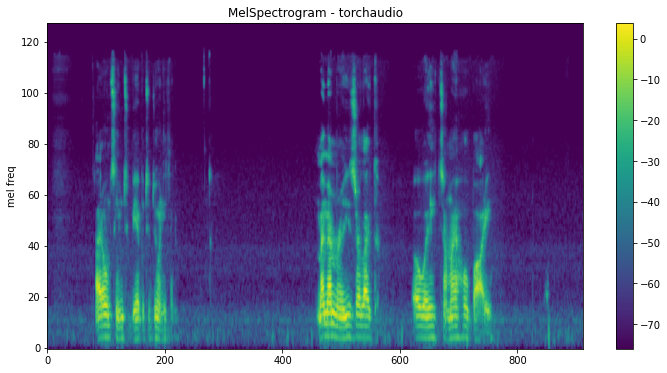

In [103]:
waveform = train_wavs[15][0]
sample_rate = train_wavs[15][1]

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)

melspec = librosa.power_to_db(melspec)

plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

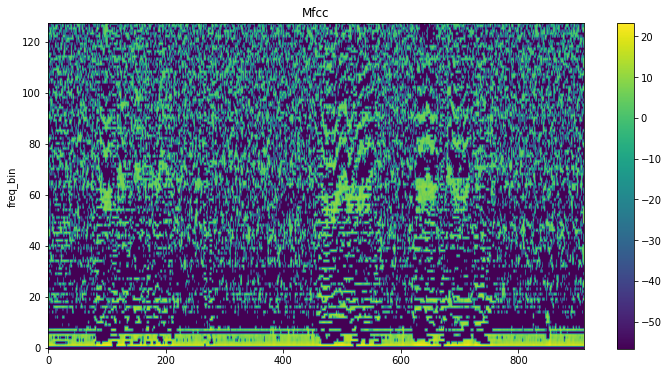

In [104]:
sample_rate=44100
n_fft=2048
win_length=None
hop_length=512
n_mels=128
n_mfcc=128

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(waveform)
mfcc = librosa.power_to_db(mfcc)
plot_spectrogram(mfcc[0], title="Mfcc")

In [11]:
def get_melspectrogram(waveforms, sample_rate=44100, n_fft=2048,
                       win_length=None, hop_length=1024, n_mels=64):
    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
    )

    result = []
    for wav in waveforms:
        mel = mel_spectrogram(wav[0])
        mel = librosa.power_to_db(mel)
        result.append(mel[0])
    return result

def get_mfcc(waveforms, sample_rate=44100, n_fft=2048, win_length=None,
             hop_length=1024, n_mels=64, n_mfcc=64):
    mfcc_transform = T.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mels,
            "hop_length": hop_length,
            "mel_scale": "htk",
        },
    )
    
    result = []
    for wav in waveforms:
        mfcc = mfcc_transform(wav[0])
        mfcc = librosa.power_to_db(mfcc)
        result.append(mfcc[0])
    return result

In [12]:
X_train_mel = get_melspectrogram(train_wavs)
X_valid_mel = get_melspectrogram(valid_wavs)

X_train_mfcc = get_mfcc(train_wavs)
X_valid_mfcc = get_mfcc(valid_wavs)

y_train = train_videos['EmotionMaxVote']
y_valid = valid_videos['EmotionMaxVote']

In [19]:
def pad(samples, max_len=400, n_mels=64):
    result = []
    for i in samples:
        if i.shape[1] < max_len:
            min = i.min()
            temp = np.full((n_mels, max_len - i.shape[1]), min, dtype=np.float32) 
            result.append(np.concatenate((i, temp), axis=1))
        else:
            temp = i[:,:max_len]
            result.append(temp)
    return np.array(result)

In [20]:
X_train_mel = pad(X_train_mel)
X_valid_mel = pad(X_valid_mel)

X_train_mfcc = pad(X_train_mfcc)
X_valid_mfcc = pad(X_valid_mfcc)

# Audio model

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

In [65]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv1d(64, 64, kernel_size=16)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv1d(64, 64, kernel_size=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.drop2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv1d(64, 64, kernel_size=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)
        self.drop3 = nn.Dropout(0.2)

        self.conv4 = nn.Conv1d(64, 64, kernel_size=2)
        self.bn4 = nn.BatchNorm1d(64)
        self.pool4 = nn.MaxPool1d(2)
        self.drop4 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(1472, 300)
        self.fc2 = nn.Linear(300, 50)
        self.fc3 = nn.Linear(50, 7)

        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = F.relu(output)
        output = self.pool1(output)
        output = self.drop1(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = F.relu(output)
        output = self.pool2(output)
        output = self.drop2(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = F.relu(output)
        output = self.pool3(output)
        output = self.drop3(output)

        output = self.conv4(output)
        output = self.bn4(output)
        output = F.relu(output)
        output = self.pool4(output)
        output = torch.flatten(output, 1)
        output = self.drop4(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)

        return output

    def infere(self, input):
        output = self.forward(input)
        return F.softmax(output, dim=1)

    def train_model(self, 
                    x_train, 
                    y_train, 
                    x_test, 
                    y_test, 
                    optimizer, 
                    scheduler, 
                    batch_size=16, 
                    epoch=10):
        result = {"acc": [], "f1": []}
        model = self
        model.train()
        for i in range(epoch):
            losses = []
            x_batch = []
            y_batch = []
            for batch_idx, (x, y) in enumerate(zip(x_train, y_train)):
                x_batch.append(x)
                y_batch.append(y)

                if len(x_batch)==batch_size:
                    x_batch = torch.tensor(x_batch)
                    y_batch = torch.tensor(y_batch)

                    data = x_batch.to('cpu')
                    target = y_batch.to('cpu')

                    output = model(data)

                    loss = self.loss(output.squeeze(), target)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    losses.append(loss.item())

                    x_batch = []
                    y_batch = []
            scheduler.step()
            metrics = self.test(x_test, y_test)
            result["acc"].append(metrics[0])
            result["f1"].append(metrics[1])
            print(f'Epoch {i}. Loss: {np.mean(losses)}. Accuracy: {metrics[0]} F1: {metrics[1]}')
        return result
    
    def test(self, x_test, y_test):
        model = self
        model.eval()
        test_sample = torch.tensor(x_test).to('cpu')
        test_target = y_test
        out = model.infere(test_sample)
        y_true = test_target
        y_pred = out.argmax(dim=-1).to('cpu').numpy()
        acc = balanced_accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="micro")
        return [acc, f1]

# Train Audio

In [24]:
def draw_results(mel_res, mfcc_res):
    plt.figure(figsize=(16, 8))
    X = [i for i in range(len(mel_res['acc']))]
    plt.plot(X, mel_res['acc'], label="mel_accuracy")
    plt.plot(X, mel_res['f1'], label="mel_f1")
    plt.plot(X, mfcc_res['acc'], label="mfcc_accuracy")
    plt.plot(X, mfcc_res['f1'], label="mfcc_f1")
    plt.legend(loc='lower right')
    plt.show()

In [69]:
#Model with Melspectrogram features
mel_model = Model()
mel_model.to('cpu')

optimizer = optim.Adam(mel_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

result1 = mel_model.train_model(X_train_mel, 
                  y_train, 
                  X_valid_mel,
                  y_valid,
                  optimizer=optimizer, 
                  scheduler=scheduler,
                  epoch=15)
mel_model.test(X_valid_mel, y_valid)

#Model with MFCC features
mfcc_model = Model()
mfcc_model.to('cpu')

optimizer = optim.Adam(mfcc_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

result2 = mfcc_model.train_model(X_train_mfcc, 
                  y_train, 
                  X_valid_mfcc,
                  y_valid,
                  optimizer=optimizer, 
                  scheduler=scheduler,
                  epoch=15)
mfcc_model.test(X_valid_mfcc, y_valid)

Epoch 0. Loss: 1.7216266203617705. Accuracy: 0.1584527035746548 F1: 0.19724770642201836
Epoch 1. Loss: 1.715646032837854. Accuracy: 0.1470383275261324 F1: 0.3669724770642202
Epoch 2. Loss: 1.649796820205191. Accuracy: 0.1332171893147503 F1: 0.3440366972477064
Epoch 3. Loss: 1.578052526798801. Accuracy: 0.1397793263646922 F1: 0.3394495412844037
Epoch 4. Loss: 1.557340183119843. Accuracy: 0.14088269454123112 F1: 0.3440366972477064
Epoch 5. Loss: 1.547152419021164. Accuracy: 0.1396631823461092 F1: 0.3256880733944954
Epoch 6. Loss: 1.5262354033580725. Accuracy: 0.14268292682926828 F1: 0.3302752293577982
Epoch 7. Loss: 1.5127946008806643. Accuracy: 0.14076655052264808 F1: 0.3302752293577982
Epoch 8. Loss: 1.5119798192079517. Accuracy: 0.13681765389082462 F1: 0.3165137614678899
Epoch 9. Loss: 1.5007786906283835. Accuracy: 0.15320686540198736 F1: 0.3577981651376147
Epoch 10. Loss: 1.4848283771155537. Accuracy: 0.152787456445993 F1: 0.3669724770642202
Epoch 11. Loss: 1.4756325707919355. Accura

[0.18416827977803588, 0.3440366972477064]

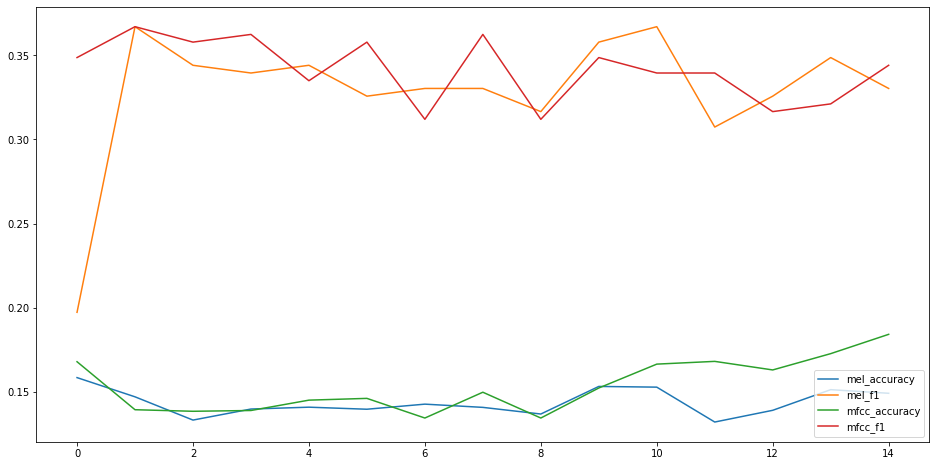

In [70]:
draw_results(result1, result2)

# Предобработка (Текст)

In [33]:
! pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 8.2 MB 6.8 MB/s 


In [34]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import pymorphy2

In [35]:
#Удаление примеров с пустым полем transcript и label
train_texts = train_texts.assign(label=train_videos.EmotionMaxVote)
train_texts = train_texts.dropna(subset=['transcript', 'label'])

valid_texts = valid_texts.assign(label=valid_videos.EmotionMaxVote)
valid_texts = valid_texts.dropna(subset=['transcript', 'label'])

In [36]:
y_train_text = list(train_texts.label)
train_data = list(train_texts.transcript)

y_valid_text = list(valid_texts.label)
valid_data = list(valid_texts.transcript)

In [37]:
def remove_punctuation(tokens):
    punctuation = list(string.punctuation)
    result = []
    for i in tokens:
        if i.strip().lower() not in punctuation:
            result.append(i.strip().lower())
    return result


def normalize(tokens):
    morph = pymorphy2.MorphAnalyzer()

    result = []
    for i in tokens:
        result.append(morph.parse(i)[0].normal_form)
    return result


def remove_stopwords(tokens):
    russian_stopwords = stopwords.words("russian")
    result = []
    for i in tokens:
        if i.strip().lower() not in russian_stopwords:
            result.append(i.strip())
    return result


#Удаление знаков препинания, нормализация, удаление стоп-слов
def filter_data(data):
    filtered_data = []
    tokens_list = []
    sentence_list = []
    for text in data:
        tokens = word_tokenize(text)
        tokens = remove_punctuation(tokens)
        tokens = normalize(tokens)
        tokens = remove_stopwords(tokens)
        filtered_data.append(' '.join(tokens))
    
    return filtered_data

In [38]:
nltk.download('punkt')
nltk.download('stopwords')

train_filtered = filter_data(train_data)
valid_filtered = filter_data(valid_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Анализ (текст)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


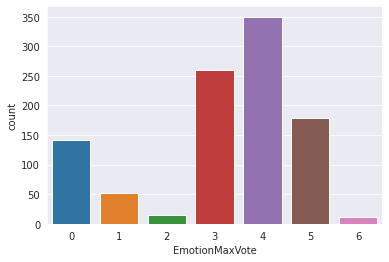

In [ ]:
#Распределение по категориям эмоций
sns.set_style("darkgrid")
sns.countplot(y_train)

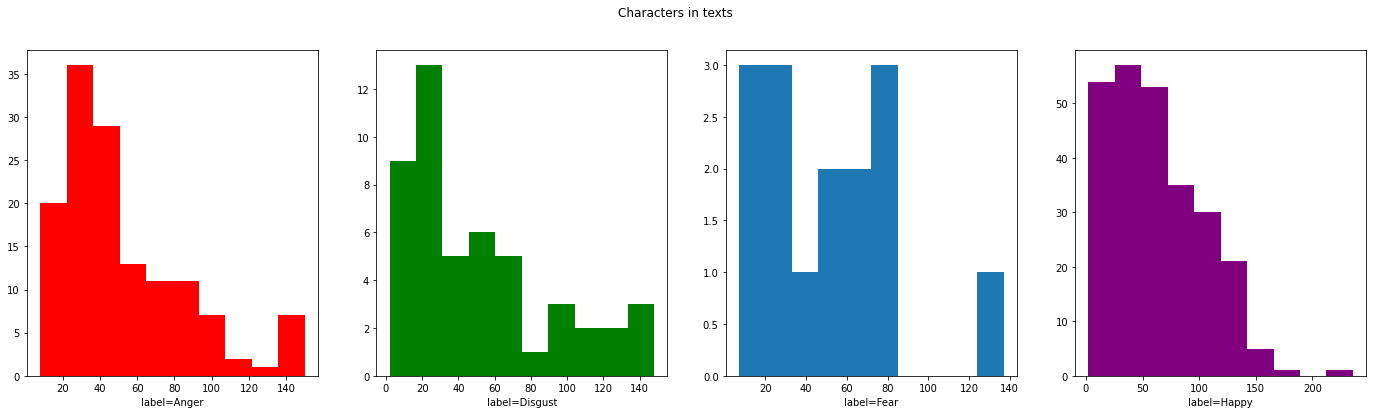

In [ ]:
#Распределение количества символов в примере по эмоциям
d = {"text": train_filtered, "label": y_train_text}
df = pd.DataFrame(data=d)

fig,(ax0,ax1,ax2,ax3)=plt.subplots(1,4,figsize=(24,6))
text_len=df[df.label==0]['text'].str.len()
ax0.hist(text_len, color='red')
ax0.set_xlabel("label=Anger")

text_len=df[df.label==1]['text'].str.len()
ax1.hist(text_len, color='g')
ax1.set_xlabel("label=Disgust")

text_len=df[df.label==2]['text'].str.len()
ax2.hist(text_len)
ax2.set_xlabel("label=Fear")

text_len=df[df.label==3]['text'].str.len()
ax3.hist(text_len, color='purple')
ax3.set_xlabel("label=Happy")

fig.suptitle('Characters in texts')
plt.show()

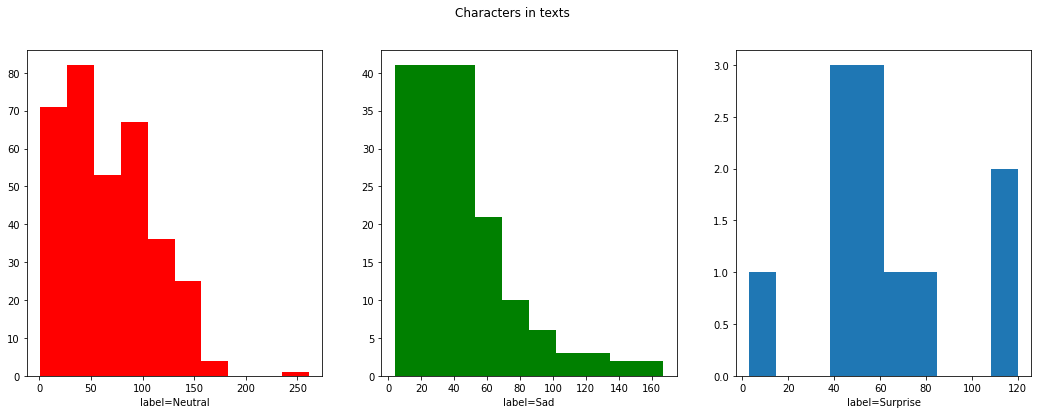

In [ ]:
fig,(ax4,ax5,ax6)=plt.subplots(1,3,figsize=(18,6))
text_len=df[df.label==4]['text'].str.len()
ax4.hist(text_len, color='red')
ax4.set_xlabel("label=Neutral")

text_len=df[df.label==5]['text'].str.len()
ax5.hist(text_len, color='g')
ax5.set_xlabel("label=Sad")

text_len=df[df.label==6]['text'].str.len()
ax6.hist(text_len)
ax6.set_xlabel("label=Surprise")

fig.suptitle('Characters in texts')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

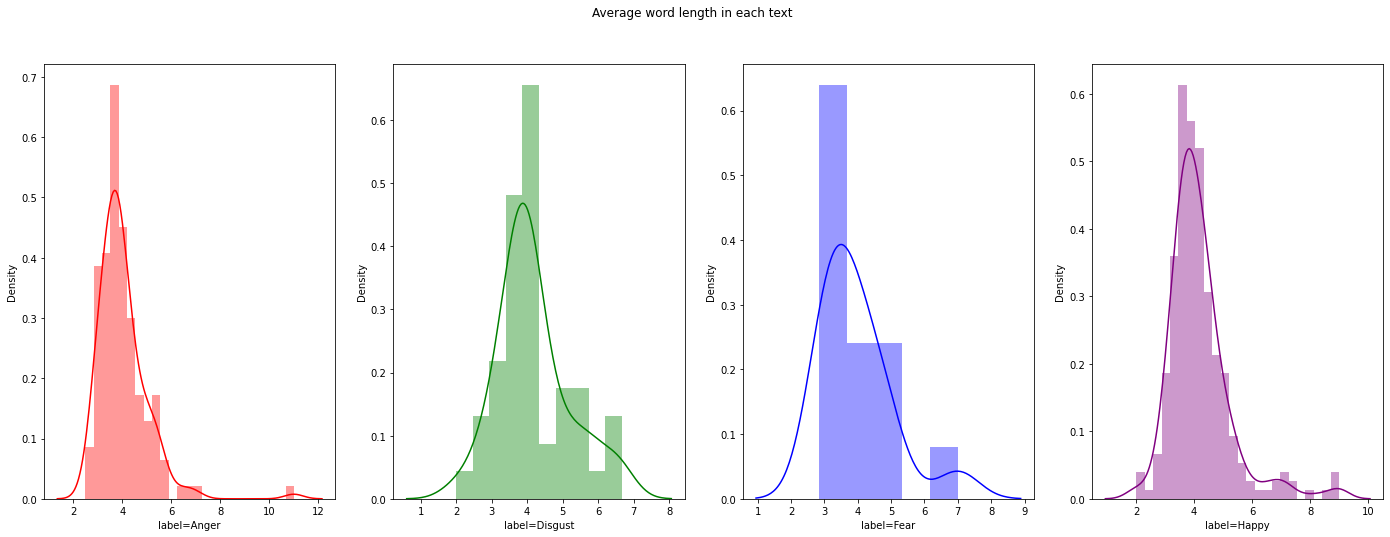

In [ ]:
#Распределение числа слов по эмоциям
fig,(ax0,ax1,ax2,ax3)=plt.subplots(1,4,figsize=(24,8))
word=df[df['label']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax0,color='red')
ax0.set_xlabel("label=Anger")

word=df[df['label']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_xlabel("label=Disgust")

word=df[df['label']==2]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='blue')
ax2.set_xlabel("label=Fear")

word=df[df['label']==3]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='purple')
ax3.set_xlabel("label=Happy")

fig.suptitle('Average word length in each text')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

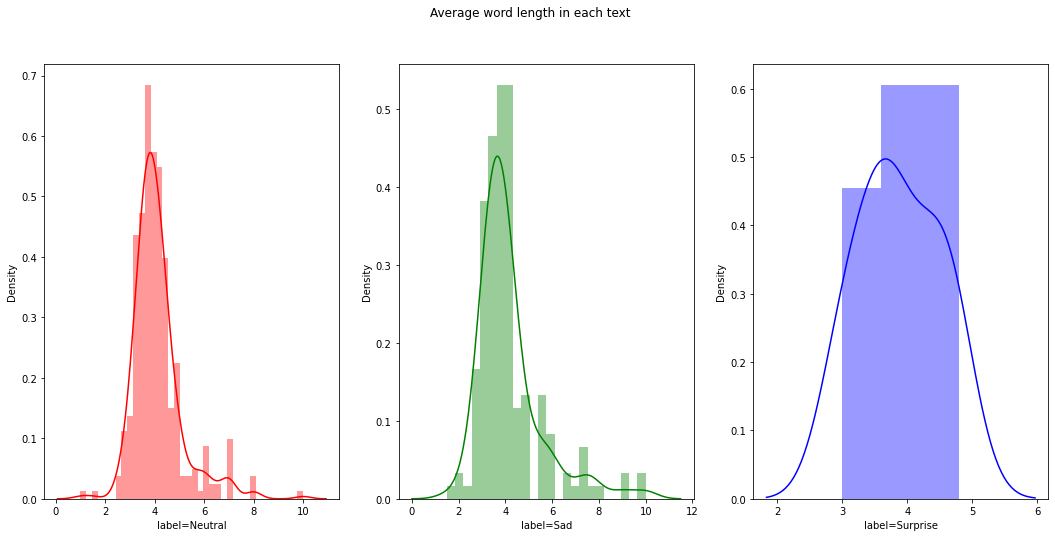

In [ ]:
fig,(ax4,ax5,ax6)=plt.subplots(1,3,figsize=(18,8))
word=df[df['label']==4]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax4,color='red')
ax4.set_xlabel("label=Neutral")

word=df[df['label']==5]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax5,color='green')
ax5.set_xlabel("label=Sad")

word=df[df['label']==6]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax6,color='blue')
ax6.set_xlabel("label=Surprise")

fig.suptitle('Average word length in each text')
plt.show()

# Извлечение признаков (текст)

In [39]:
#Tf-Idf признаки
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_train_text = vectorizer.fit_transform(train_filtered)
X_valid_text = vectorizer.transform(valid_filtered)

X_train_densed = pd.DataFrame(data=X_train_text.todense(), columns=vectorizer.get_feature_names())
X_train_densed = np.asarray(X_train_densed)
X_valid_densed = pd.DataFrame(data=X_valid_text.todense(), columns=vectorizer.get_feature_names())
X_valid_densed = np.asarray(X_valid_densed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Построение первой модели
Выбор лучшего варианта ансамбля из библиотеки sklearn

In [40]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [41]:
#Тестирование различных моделей для ансамблей
tree = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=456)
forest = RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=456, n_jobs=-1)
svc = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(random_state=456, tol=1e-5))
neigh = KNeighborsClassifier(n_neighbors=3)
gnb = GaussianNB()

#Train separetely
tree.fit(X_train_text, y_train_text)
y_pred = tree.predict(X_valid_text)
print(f"Decision Tree: Accuracy: {balanced_accuracy_score(y_pred, y_valid_text)}. F1: {f1_score(y_pred, y_valid_text, average='micro')}")

forest.fit(X_train_text, y_train_text)
y_pred = forest.predict(X_valid_text)
print(f"Random Forest: Accuracy: {balanced_accuracy_score(y_pred, y_valid_text)}. F1: {f1_score(y_pred, y_valid_text, average='micro')}")

svc.fit(X_train_text, y_train_text)
y_pred = svc.predict(X_valid_text)
print(f"LinearSVC: Accuracy: {balanced_accuracy_score(y_pred, y_valid_text)}. F1: {f1_score(y_pred, y_valid_text, average='micro')}")

Decision Tree: Accuracy: 0.11785714285714285. F1: 0.3302752293577982


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Random Forest: Accuracy: 0.3039028944911298. F1: 0.3853211009174312
LinearSVC: Accuracy: 0.17530443687526437. F1: 0.3394495412844037


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [71]:
#Эксперименты с различными ансамблями
tree = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=456)
forest = RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=456, n_jobs=-1)
svc = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(random_state=456, tol=1e-5))

estimators = [('svc', svc), ('tree', tree)]

clf = StackingClassifier(
    estimators=estimators,
    final_estimator=forest,
    passthrough=True,
    n_jobs=-1
)

clf.fit(X_train_text, y_train_text)
y_pred = clf.predict(X_valid_text)
print(f"Stacking Ensemble: Accuracy: {balanced_accuracy_score(y_pred, y_valid_text)}. F1: {f1_score(y_pred, y_valid_text, average='micro')}")

clf = AdaBoostClassifier(n_estimators=100, random_state=0)

clf.fit(X_train_text, y_train_text)
y_pred = clf.predict(X_valid_text)
print(f"AdaBoost Ensemble: Accuracy: {balanced_accuracy_score(y_pred, y_valid_text)}. F1: {f1_score(y_pred, y_valid_text, average='micro')}")

clf = BaggingClassifier(base_estimator=forest,
                        n_estimators=50,
                        random_state=456,
                        n_jobs=-1)

clf.fit(X_train_text, y_train_text)
y_pred = clf.predict(X_valid_text)
print(f"Bagging Ensemble: Accuracy: {balanced_accuracy_score(y_pred, y_valid_text)}. F1: {f1_score(y_pred, y_valid_text, average='micro')}")

clf = ExtraTreesClassifier(n_estimators=50,
                           bootstrap=True,
                           random_state=0,
                           n_jobs=-1)

clf.fit(X_train_text, y_train_text)
y_pred = clf.predict(X_valid_text)
print(f"ExtraTrees Ensemble: Accuracy: {balanced_accuracy_score(y_pred, y_valid_text)}. F1: {f1_score(y_pred, y_valid_text, average='micro')}")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Stacking Ensemble: Accuracy: 0.1846969696969697. F1: 0.3073394495412844


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


AdaBoost Ensemble: Accuracy: 0.18981481481481483. F1: 0.3761467889908257


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Bagging Ensemble: Accuracy: 0.30603448275862066. F1: 0.38073394495412843
ExtraTrees Ensemble: Accuracy: 0.19279541852022294. F1: 0.3944954128440367


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [75]:
ensemble_model = ExtraTreesClassifier(n_estimators=90,
                              bootstrap=True,
                              random_state=0,
                              n_jobs=-1)

ensemble_model.fit(X_train_densed, y_train_text)
y_pred = ensemble_model.predict(X_valid_densed)
print(f"Accuracy: {balanced_accuracy_score(y_pred, y_valid_text)}. F1: {f1_score(y_pred, y_valid_text, average='micro')}")

Accuracy: 0.26283846872082167. F1: 0.4036697247706422


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# Вторая модель (FFN-network)

In [57]:
class FFN(nn.Module):
    def __init__(self, input_size):
        super(FFN, self).__init__()
        self.loss = nn.CrossEntropyLoss()
        self.ac = F.relu

        self.fc1 = nn.Linear(input_size, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 20)
        self.fc4 = nn.Linear(20, 7)

        self.bn1 = nn.BatchNorm1d(500)
        self.bn2 = nn.BatchNorm1d(100)
        self.bn3 = nn.BatchNorm1d(20)

        self.dr1 = nn.Dropout(0.3)
        self.dr2 = nn.Dropout(0.3)
        self.dr3 = nn.Dropout(0.3)

        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight)
        nn.init.kaiming_uniform_(self.fc4.weight)

    def forward(self, input):
        output = self.fc1(input)
        output = self.bn1(output)
        output = self.ac(output)
        output = self.dr1(output)

        output = self.fc2(output)
        output = self.bn2(output)
        output = self.ac(output)
        output = self.dr2(output)

        output = self.fc3(output)
        output = self.bn3(output)
        output = self.ac(output)
        output = self.dr3(output)

        output = self.fc4(output)
        return output
        #return F.softmax(output, dim=1)

    def infere(self, input):
        output = self.forward(input)
        return F.softmax(output, dim=1)

    def train_model(self, 
                    x_train, 
                    y_train, 
                    x_test, 
                    y_test, 
                    batch_size=16, 
                    epoch=10):
        model = self
        result = {"acc": [], "f1": []}
        model.train()
        optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        for i in range(epoch):
            losses = []
            x_batch = []
            y_batch = []
            for batch_idx, (x, y) in enumerate(zip(x_train, y_train)):
                x_batch.append(x)
                y_batch.append(y)

                if len(x_batch)==batch_size:
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)

                    data = torch.tensor(x_batch).float().to('cpu')
                    target = torch.tensor(y_batch).to('cpu')

                    output = model(data)

                    loss = self.loss(output.squeeze(), target)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    losses.append(loss.item())

                    x_batch = []
                    y_batch = []
            scheduler.step()
            metrics = self.test(x_test, y_test)
            result["acc"].append(metrics[0])
            result["f1"].append(metrics[1])
            print(f'Epoch {i}. Loss: {np.mean(losses)}. Accuracy: {metrics[0]} F1: {metrics[1]}')
        return result
    
    def test(self, x_test, y_test):
        model = self
        model.eval()
        test_sample = torch.tensor(x_test).float().to('cpu')
        test_target = y_test
        out = model.infere(test_sample)
        y_true = test_target
        y_pred = out.argmax(dim=-1).to('cpu').numpy()
        acc = balanced_accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="micro")
        return [acc, f1]

In [76]:
ffn_model = FFN(
    input_size=X_train_densed.shape[1])

ffn_model.to('cpu')

result = ffn_model.train_model(X_train_densed, 
                  y_train_text, 
                  X_valid_densed,
                  y_valid_text,
                  epoch=15)
print("\nResult:")
ffn_model.test(X_valid_densed, y_valid_text)

Epoch 0. Loss: 2.6964439447375312. Accuracy: 0.16763658308851997 F1: 0.2018348623853211
Epoch 1. Loss: 1.6143937128177588. Accuracy: 0.13875338753387534 F1: 0.29357798165137616
Epoch 2. Loss: 1.2141330846841785. Accuracy: 0.15398761130468447 F1: 0.3073394495412844
Epoch 3. Loss: 0.9018376534399779. Accuracy: 0.16108917279648988 F1: 0.3165137614678899
Epoch 4. Loss: 0.6653014667656111. Accuracy: 0.15740095496193057 F1: 0.3165137614678899
Epoch 5. Loss: 0.4986708742984827. Accuracy: 0.16105949154729643 F1: 0.3211009174311927
Epoch 6. Loss: 0.38008739594100177. Accuracy: 0.15757517098980514 F1: 0.3119266055045872
Epoch 7. Loss: 0.294099367507126. Accuracy: 0.16280165182604206 F1: 0.3256880733944954
Epoch 8. Loss: 0.24263116096456847. Accuracy: 0.15565879468318491 F1: 0.3119266055045872
Epoch 9. Loss: 0.20895846690172734. Accuracy: 0.1550200025809782 F1: 0.3119266055045872
Epoch 10. Loss: 0.1851100653571927. Accuracy: 0.15484578655310363 F1: 0.3165137614678899
Epoch 11. Loss: 0.16843311394

[0.16885791715060008, 0.3623853211009174]

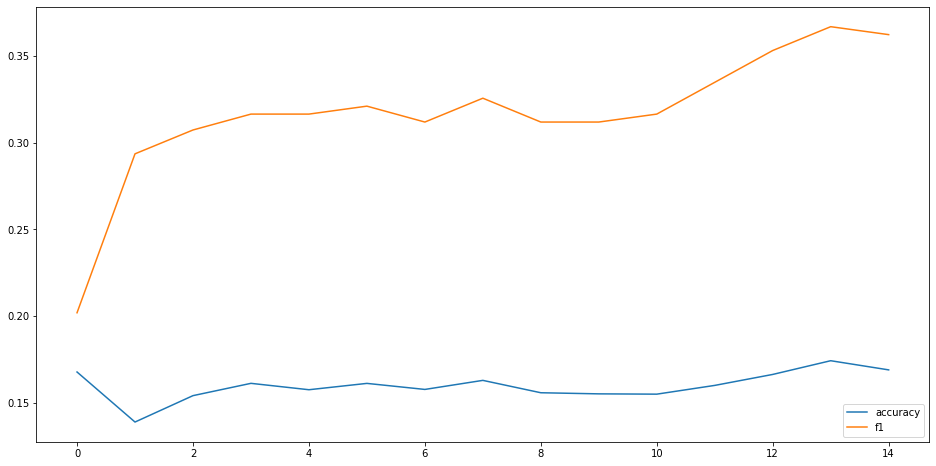

In [77]:
plt.figure(figsize=(16, 8))
X = [i for i in range(len(result['acc']))]
plt.plot(X, result['acc'], label="accuracy")
plt.plot(X, result['f1'], label="f1")
plt.legend(loc='lower right')
plt.show()

# Final model

In [89]:
#Необходимо учитывать, что у каждой модели разный тип признаков
class FinalModel(nn.Module):
    def __init__(self, models):
        super(FinalModel, self).__init__()
        
        self.mel_model = models['mel']
        self.mfcc_model = models['mfcc']
        self.ensemble_model = models['ensemble']
        self.ffn_model = models['ffn']

        self.ac = F.relu
        self.dr = nn.Dropout(0.5)
        self.fc1 = nn.Linear(28, 14)
        self.fc2 = nn.Linear(14, 7)

        self.loss = torch.nn.CrossEntropyLoss()

        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, input):
        out1 = self.mel_model.infere(input['mel'])
        out2 = self.mfcc_model.infere(input['mfcc'])
        out3 = torch.tensor(self.ensemble_model.predict_proba(input['ensemble']))
        out4 = self.ffn_model.infere(input['ffn'])

        output = torch.cat((out1, out2, out3, out4), 1).float()

        output = self.fc1(output)
        ouptut = self.ac(output)
        output = self.dr(output)
        output = self.fc2(output)

        return F.log_softmax(output, dim=1)

    def train_model(self, 
                    x_train, 
                    y_train, 
                    x_test, 
                    y_test, 
                    optimizer,
                    scheduler,
                    batch_size=16, 
                    epoch=10):
        mel_train = x_train['mel']
        mfcc_train = x_train['mfcc']
        text_train = x_train['text']

        mel_valid = x_test['mel']
        mfcc_valid = x_test['mfcc']
        text_valid = x_test['text']

        result = {"acc": [], "f1": []}
        model = self
        model.train()
        for i in range(epoch):
            losses = []
            x_mel_batch = []
            x_mfcc_batch = []
            x_text_batch = []
            y_batch = []
            for j in range(len(mel_train)):
                x_mel_batch.append(mel_train[j])
                x_mfcc_batch.append(mfcc_train[j])
                x_text_batch.append(text_train[j])

                y_batch.append(y_train[j])

                if len(y_batch)==batch_size:
                    x_mel_batch = torch.tensor(x_mel_batch)
                    x_mfcc_batch = torch.tensor(x_mfcc_batch)
                    x_ffn_batch = torch.tensor(x_text_batch)
                    y_batch = torch.tensor(y_batch)

                    data = {"mel": x_mel_batch.float().to('cpu'),
                            "mfcc": x_mfcc_batch.float().to('cpu'),
                            "ensemble": x_text_batch,
                            "ffn": x_ffn_batch.float().to('cpu')}
                    target = y_batch.to('cpu')

                    output = model(data)

                    loss = self.loss(output.squeeze(), target)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    losses.append(loss.item())

                    x_mel_batch = []
                    x_mfcc_batch = []
                    x_text_batch = []
                    y_batch = []
            scheduler.step()
            metrics = self.test(x_test, y_test)
            result["acc"].append(metrics[0])
            result["f1"].append(metrics[1])
            print(f'Epoch {i}. Loss: {np.mean(losses)}. Accuracy: {metrics[0]} F1: {metrics[1]}')
        return result
    
    def test(self, x_test, y_test):
        model = self
        model.eval()

        test_mel = torch.tensor(x_test['mel']).float().to('cpu')
        test_mfcc = torch.tensor(x_test['mfcc']).float().to('cpu')
        test_ensemble = x_test['text']
        test_ffn = torch.tensor(x_test['text']).float().to('cpu')
        test_target = y_test

        test_sample = {"mel": test_mel,
                       "mfcc": test_mfcc,
                       "ensemble": test_ensemble,
                       "ffn": test_ffn}
        out = model(test_sample)
        y_true = test_target
        y_pred = out.argmax(dim=-1).to('cpu').numpy()
        acc = balanced_accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="micro")
        return [acc, f1]

In [119]:
#Замораживание слоев обученных моделей
for i in mel_model.parameters():
    i.requires_grad = False

for i in mfcc_model.parameters():
    i.requires_grad = False

for i in ffn_model.parameters():
    i.requires_grad = False

X_train = {"mel": X_train_mel,
           "mfcc": X_train_mfcc,
           "text": X_train_densed}
X_valid = {"mel": X_valid_mel,
           "mfcc": X_valid_mfcc,
           "text": X_valid_densed}

models = {"mel": mel_model,
          "mfcc": mfcc_model,
          "ensemble": ensemble_model,
          "ffn": ffn_model}

final_model = FinalModel(models)

final_model.to('cpu')

optimizer = optim.AdamW(final_model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 9], gamma=0.4)

result = final_model.train_model(X_train, 
                  y_train_text, 
                  X_valid,
                  y_valid_text,
                  optimizer,
                  scheduler,
                  epoch=30)
print("\nResult:")
final_model.test(X_valid, y_valid_text)

Epoch 0. Loss: 1.8410617907842. Accuracy: 0.1594786424054717 F1: 0.29357798165137616
Epoch 1. Loss: 1.616933696511863. Accuracy: 0.1524454768357207 F1: 0.3853211009174312
Epoch 2. Loss: 1.4540312221084817. Accuracy: 0.14942573235256162 F1: 0.38073394495412843
Epoch 3. Loss: 1.3771216212839321. Accuracy: 0.15116789263130728 F1: 0.3853211009174312
Epoch 4. Loss: 1.3065353061841882. Accuracy: 0.15116789263130728 F1: 0.3853211009174312
Epoch 5. Loss: 1.2411808095116545. Accuracy: 0.15116789263130728 F1: 0.3853211009174312
Epoch 6. Loss: 1.1802092911540598. Accuracy: 0.15645889792231257 F1: 0.389908256880734
Epoch 7. Loss: 1.1229541897773743. Accuracy: 0.1594786424054717 F1: 0.3944954128440367
Epoch 8. Loss: 1.068905480529951. Accuracy: 0.16487933926958315 F1: 0.4036697247706422
Epoch 9. Loss: 1.0309912355049797. Accuracy: 0.1655181313717899 F1: 0.4036697247706422
Epoch 10. Loss: 1.010860736819281. Accuracy: 0.16853787585494903 F1: 0.408256880733945
Epoch 11. Loss: 0.991030860638273. Accura

[0.16714414763195254, 0.3944954128440367]

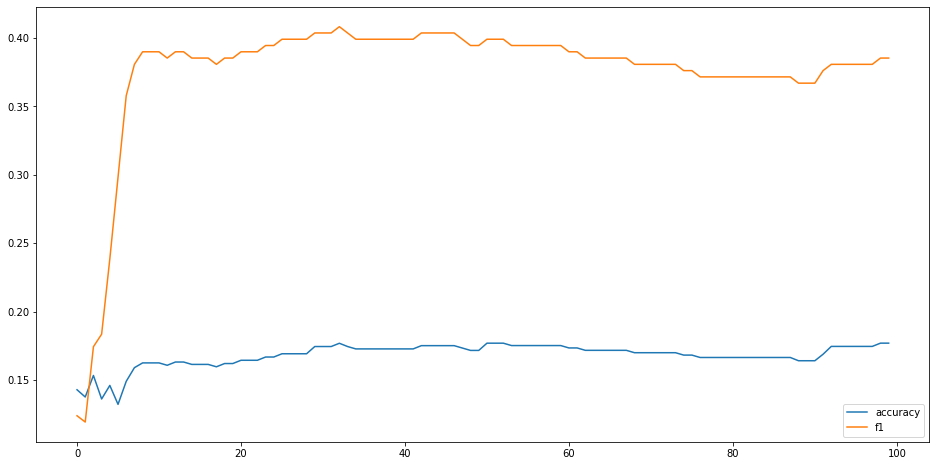

In [116]:
plt.figure(figsize=(16, 8))
X = [i for i in range(len(result['acc']))]
plt.plot(X, result['acc'], label="accuracy")
plt.plot(X, result['f1'], label="f1")
plt.legend(loc='lower right')
plt.show()